In [1]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../../")

In [2]:
from collections import defaultdict
import random
import warnings
from itertools import chain
from multiprocessing import cpu_count
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import ray

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from gensim.models import Word2Vec, Doc2Vec

import tensorflow as tf
from keras.utils import to_categorical
from keras.initializers import Constant
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, 
    Embedding, Bidirectional, LSTM, GRU, Attention, 
    BatchNormalization, Conv1D, MaxPooling1D, TimeDistributed,
    SpatialDropout1D, GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from processing.utils import CleanUp, RSLP_STEMMER, SNOWBALL_STEMMER, NLP_LEMMATIZER

%matplotlib inline

clean_up = CleanUp()

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices("GPU")))

Using TensorFlow backend.


Num GPUs Available:  1


In [3]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1



In [4]:
max_words = 50000
batch_size = 32

In [6]:
ray.shutdown()
ray.init(num_cpus=cpu_count(), include_webui=False, lru_evict=True)

corpus = []

filename = f"{os.getcwd()}/../../../data/embedding/corpus.txt"
file_it = pd.read_csv(filename, header=None, iterator=True, names=["sentence"], chunksize=1000,)

@ray.remote
def carregar_frases(lines):
    import os
    import sys

    sys.path.append(f"{os.getcwd()}/../../")
    from processing.utils import CleanUp, SNOWBALL_STEMMER
    clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)
    
    lines = lines["sentence"].tolist()
    return [clean_up.fit(line) for line in lines]

i, itera = 0, []
for lines in file_it:
    itera.append(lines)
    if i == 10:
        break
    i += 1
corpus = list(chain(*ray.get([carregar_frases.remote(lines) for lines in itera])))

ray.shutdown()

2020-06-05 00:56:16,305	INFO resource_spec.py:204 -- Starting Ray with 4.05 GiB memory available for workers and up to 2.05 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


In [7]:
df = pd.read_csv(f"{os.getcwd()}/../../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [8]:
print(random.choice(textos))
print(f'Dataset size: {len(textos)}')
# print(df[df['x'] == ''].index)
# print(df.loc[250])

for item in list(textos[:, 0]):
    corpus.append(item)
print(f'Corpus size: {len(corpus)}')

['toda noite chiado peito nao consigo respirar puta que pariu' 1]
Dataset size: 2321
Corpus size: 13321


In [9]:
maxlen = 0
for phrase in corpus:
    size = len(phrase.split())
    maxlen = size if size > maxlen else maxlen
print(f'Maxlen: {maxlen}')

Maxlen: 153


In [10]:
# word_counts = defaultdict(int)
# for phrases in textos[:, 0]:
#     for word in phrases.split():
#         word_counts[word] += 1
# v_count = len(word_counts.keys())
# words_list = list(word_counts.keys())
# word_index = dict((word, i) for i, word in enumerate(words_list))

# X = []
# for phrases in textos[:, 0]:
#     xp = []
#     for word in phrases.split():
#         xp.append(word_index[word])
#     X.append(xp)
# y = textos[:, 1].astype(np.int).ravel()
# y = to_categorical(y, classes)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# tokenizer = Tokenizer(num_words=max_words)
# X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
# X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

              precision    recall  f1-score   support

           0       0.62      0.97      0.76       276
           1       0.78      0.15      0.25       189

    accuracy                           0.64       465
   macro avg       0.70      0.56      0.50       465
weighted avg       0.69      0.64      0.55       465



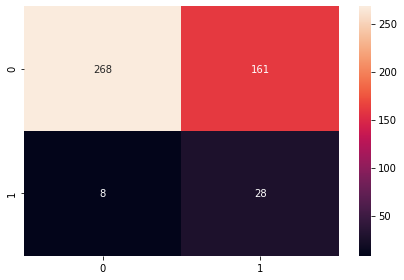

In [11]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=False, oov_token='<OOV>', char_level=False)
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

clf = LogisticRegression(
    random_state=0,
    n_jobs=-1,
    max_iter=3000,
    multi_class="ovr"
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [12]:
X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()
# y = to_categorical(y, classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

tokenizer = Tokenizer(num_words=max_words, lower=False, oov_token='<OOV>', char_level=False)
tokenizer.fit_on_texts(corpus)
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

print(f"Vocab size: {vocab_size}")

Vocab size: 23014


In [13]:
word_index = tokenizer.word_index

embeddings_index = {}
w2v = Word2Vec.load(f"{os.getcwd()}/../../ai/models/w2v.model")

for phrase in X:
    for word in phrase.split():
        try:
            embeddings_index[word] = w2v.wv[word]
        except:
            pass
print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Embedding Matrix size:', embedding_matrix.shape)

Found 5605 word vectors.
Embedding Matrix size: (23014, 300)


In [14]:
# X_train[0], X_test[0]

In [19]:
model = Sequential(name='WordEmbeddings')
model.add(
    Embedding(
        len(word_index) + 1,
        300, 
        embeddings_initializer=Constant(embedding_matrix),
        trainable=False,
    )
)
# model.add(Dropout(0.5))
# model.add(Conv1D(16, 2, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D())
# model.add(Conv1D(16, 2, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D())
# model.add(Conv1D(16, 2, padding='valid', activation='relu', strides=1))
# model.add(BatchNormalization())
# model.add(MaxPooling1D())
# model.add(Dropout(0.5))
# model.add(Bidirectional(LSTM(8, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(GlobalMaxPooling1D())
# model.add(Flatten())
# model.add(Conv1D(128, 2, padding='same', activation='relu', strides=1))
# model.add(GlobalMaxPooling1D())
model.add(
    Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(1e-3),
        activity_regularizer=regularizers.l2(1e-3)
    )
)
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "WordEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         6904200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 7,376,521
Trainable params: 472,321
Non-trainable params: 6,904,200
____________________________________

In [20]:
epochs = 5

history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1,
    shuffle=True,
    validation_data=(X_test, y_test)
)
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', f'{round(score[1] * 100)}%')

Epoch 1/5
58/58 [==============================] - 2s 30ms/step - loss: 0.7602 - accuracy: 0.6492 - val_loss: 0.6666 - val_accuracy: 0.7161
Epoch 2/5
58/58 [==============================] - 1s 22ms/step - loss: 0.6300 - accuracy: 0.7489 - val_loss: 0.6085 - val_accuracy: 0.7634
Epoch 3/5
58/58 [==============================] - 1s 22ms/step - loss: 0.5623 - accuracy: 0.7721 - val_loss: 0.5712 - val_accuracy: 0.7699
Epoch 4/5
58/58 [==============================] - 1s 23ms/step - loss: 0.4945 - accuracy: 0.8087 - val_loss: 0.5631 - val_accuracy: 0.7699
Epoch 5/5
15/15 [==============================] - 0s 8ms/step - loss: 0.6124 - accuracy: 0.7699
Test loss: 0.6124486923217773
Test accuracy: 77%


              precision    recall  f1-score   support

           0       0.78      0.85      0.81       276
           1       0.75      0.66      0.70       189

    accuracy                           0.77       465
   macro avg       0.76      0.75      0.76       465
weighted avg       0.77      0.77      0.77       465



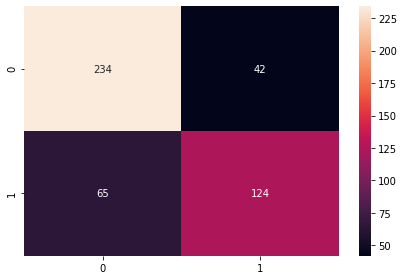

In [21]:
pred = (model.predict(X_test) > 0.5).astype(np.int).ravel()
print(classification_report(y_test, pred))

df_cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

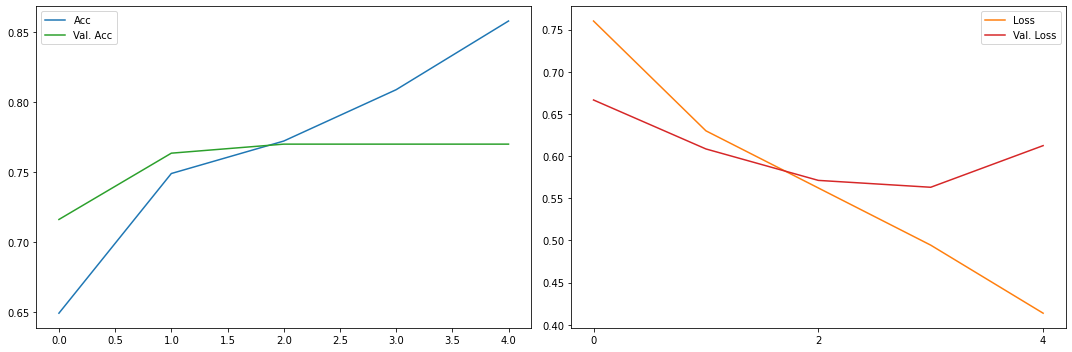

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history["accuracy"], label="Acc", c="C0")
plt.plot(history.history["val_accuracy"], label="Val. Acc", c="C2")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Loss", c="C1")
plt.plot(history.history["val_loss"], label="Val. Loss", c="C3")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()

### Do2Vec

In [115]:
d2v = Doc2Vec.load(f"{os.getcwd()}/../../ai/models/d2v.model")

n_textos = []
for texto in textos:
    doc_vec = d2v.infer_vector(texto[0].split(), epochs=100)
    n_textos.append(doc_vec)
n_textos = np.asarray(n_textos)

In [116]:
X = n_textos
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [117]:
# # For Conv & LSTM
print(X_train.shape)
print(X_test.shape)
X_train = X_train.reshape(1847, 300, -1)
X_test = X_test.reshape(462, 300, -1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

(1847, 300)
(462, 300)


In [118]:
model = Sequential(name='Doc2Vec')
model.add(Conv1D(128, 2, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Conv1D(128, 2, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D())
model.add(Conv1D(128, 2, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
# model.add(GlobalMaxPooling1D())
# model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [119]:
epochs = 5

history = model.fit(
    X_train, y_train, 
    batch_size=batch_size, 
    epochs=epochs, 
    verbose=1,
    shuffle=True,
    validation_data=(X_test, y_test)
)
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', round(score[1] * 100))

Epoch 1/5
58/58 [==============================] - 2s 36ms/step - loss: 0.6665 - accuracy: 0.6053 - val_loss: 0.6743 - val_accuracy: 0.6429
Epoch 2/5
58/58 [==============================] - 1s 10ms/step - loss: 0.6520 - accuracy: 0.6443 - val_loss: 0.6361 - val_accuracy: 0.6688
Epoch 3/5
58/58 [==============================] - 1s 10ms/step - loss: 0.6510 - accuracy: 0.6421 - val_loss: 0.6387 - val_accuracy: 0.6515
Epoch 4/5
58/58 [==============================] - 1s 11ms/step - loss: 0.6358 - accuracy: 0.6616 - val_loss: 0.6267 - val_accuracy: 0.6710
Epoch 5/5
15/15 [==============================] - 0s 4ms/step - loss: 0.6389 - accuracy: 0.6364
Test loss: 0.6389148235321045
Test accuracy: 64


              precision    recall  f1-score   support

           0       0.70      0.68      0.69       274
           1       0.55      0.57      0.56       188

    accuracy                           0.64       462
   macro avg       0.62      0.63      0.63       462
weighted avg       0.64      0.64      0.64       462



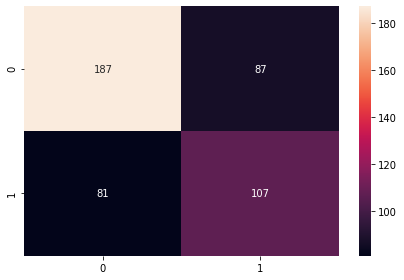

In [120]:
pred = (model.predict(X_test) > 0.5).astype(np.int).ravel()
print(classification_report(y_test, pred))

df_cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

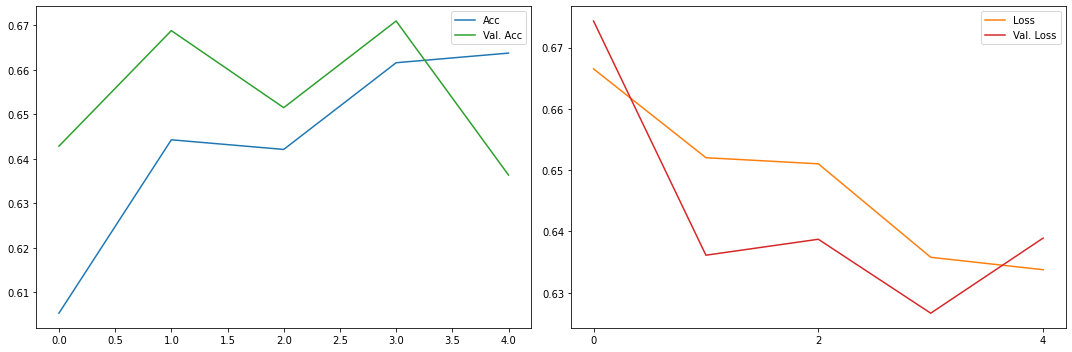

In [122]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(history.history["accuracy"], label="Acc", c="C0")
plt.plot(history.history["val_accuracy"], label="Val. Acc", c="C2")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Loss", c="C1")
plt.plot(history.history["val_loss"], label="Val. Loss", c="C3")
plt.xticks(range(0, epochs, 2))
plt.legend()
plt.tight_layout()
plt.show()